# AMV Historical Data

In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
import math

In [2]:
# 2. Đọc file csv và gắn index với giá Close
data = pd.read_csv('AMV Historical Data.csv')

# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

# Áp dụng hàm chuyển đổi cho cột "Vol."
data["Vol."] = data["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
data["Change %"] = data["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

data

df1=data.reset_index()['Price']

In [3]:
data

,Date,Price,Open,High,Low,Vol.,Change %
0,05/31/2024,3700.0,3600.0,3800.0,3600.0,1440000,0.0278
1,05/30/2024,3600.0,3600.0,3800.0,3500.0,3230000,0.0286
2,05/29/2024,3500.0,3500.0,3600.0,3500.0,522679,0.0000
3,05/28/2024,3500.0,3500.0,3600.0,3500.0,452540,0.0000
4,05/27/2024,3500.0,3500.0,3600.0,3500.0,660470,0.0000
...,...,...,...,...,...,...,...
1308,03/07/2019,14144.0,14594.0,14594.0,14144.0,28810,-0.0308
1309,03/06/2019,14594.0,14414.0,14684.0,14414.0,17250,0.0125
1310,03/05/2019,14414.0,14865.0,15045.0,14414.0,48800,-0.0303
1311,03/04/2019,14865.0,15180.0,15180.0,14865.0,19010,-0.0236


In [4]:
df1

0        3700.0
1        3600.0
2        3500.0
3        3500.0
4        3500.0
         ...   
1308    14144.0
1309    14594.0
1310    14414.0
1311    14865.0
1312    15225.0
Name: Price, Length: 1313, dtype: float64

In [5]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [7]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [8]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [9]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [10]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [11]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step, 1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0740 - val_loss: 0.0090
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0082 - val_loss: 0.0030
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0072 - val_loss: 0.0023
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0043 - val_loss: 0.0019
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0041 - val_loss: 0.0020
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0043 - val_loss: 0.0018
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0052 - val_loss: 0.0017
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0043 - val_loss: 0.0015
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0034 - val_loss: 0.0016
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

In [13]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

y_pred_new = scaler.inverse_transform(y_pred.reshape(1, -1))
y_test_new = scaler.inverse_transform(np.array([y_test], dtype=np.float32))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


In [14]:
# 11 Tính toán RMSE, MAPE và MSLE

test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 365.53656
MAPE trên tập test là: 1.75387654453516 %
MSLE trên tập test là: 0.00070573913


In [15]:
# 12. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<30):
    if(len(temp_input)>x_input.shape[1]):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.56431764]
204
1 day input [0.63835717 0.63534195 0.63534195 0.58979396 0.6049614  0.58677875
 0.58979396 0.59893097 0.60802229 0.59587007 0.6049614  0.59587007
 0.5655352  0.55945909 0.52606332 0.51395678 0.51089588 0.51089588
 0.52912422 0.52304811 0.47750011 0.46233268 0.45022614 0.45931747
 0.45324135 0.44415003 0.44108913 0.44108913 0.43807392 0.40467815
 0.40467815 0.40467815 0.40773905 0.41075426 0.40773905 0.41683037
 0.42290648 0.42290648 0.43807392 0.42898259 0.42290648 0.44716524
 0.45931747 0.45931747 0.45931747 0.45324135 0.45324135 0.45022614
 0.45022614 0.45022614 0.45022614 0.44716524 0.44415003 0.42898259
 0.45324135 0.45324135 0.45625657 0.45022614 0.44716524 0.45022614
 0.45324135 0.45625657 0.45625657 0.45931747 0.45931747 0.45324135
 0.45625657 0.46233268 0.46233268 0.46539358 0.45324135 0.44415003
 0.43501302 0.43199781 0.42898259 0.4259217  0.40467815 0.40467815
 0.39558682 0.39860204 0.39558682 0.39558682 0.40166294 0.41075426
 0.41075426 0.41381516 0.42898259

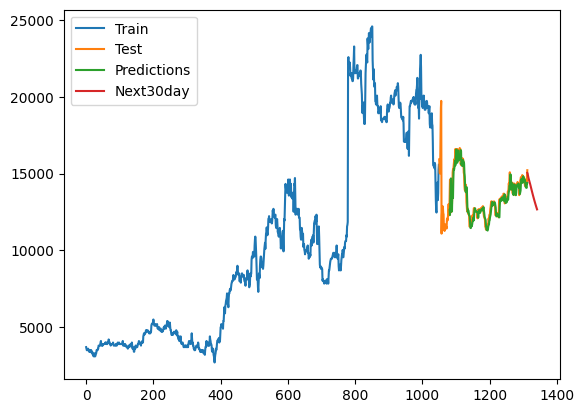

In [16]:
# 13.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+31, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predictions','Next30day'])
plt.show()

# DHT Historical Data

In [17]:
# 2. Đọc file csv và gắn index với giá Close
data = pd.read_csv('DHT Historical Data.csv')

# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

# Áp dụng hàm chuyển đổi cho cột "Vol."
data["Vol."] = data["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
data["Change %"] = data["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

data

df1=data.reset_index()['Price']

In [18]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [19]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [20]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [21]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [22]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [23]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step, 1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0375 - val_loss: 0.0026
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0048 - val_loss: 0.0019
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0019 - val_loss: 8.8819e-04
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0012 - val_loss: 8.8829e-04
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0011 - val_loss: 9.1886e-04
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0011 - val_loss: 9.2750e-04
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9.7936e-04 - val_loss: 8.0913e-04
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0010 - val_loss: 9.0649e-04
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 8.3026e-04 - val_loss: 8.2424e-04
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9.0241e-04 - val_loss: 8.1913e-04
Epoch 12

In [25]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

y_pred_new = scaler.inverse_transform(y_pred.reshape(1, -1))
y_test_new = scaler.inverse_transform(np.array([y_test], dtype=np.float32))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [26]:
# 11 Tính toán RMSE, MAPE và MSLE

test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 522.8628
MAPE trên tập test là: 2.4135014042258263 %
MSLE trên tập test là: 0.0013502949


In [27]:
# 12. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<30):
    if(len(temp_input)>x_input.shape[1]):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.06496187]
204
1 day input [0.22073446 0.22178875 0.22495486 0.22600916 0.22706345 0.22706345
 0.23128385 0.23128385 0.22706345 0.23444996 0.22495486 0.23444996
 0.23022956 0.23444996 0.24605365 0.24605365 0.25132835 0.24605365
 0.24499936 0.23972466 0.23550426 0.23128385 0.24710794 0.25554875
 0.26715566 0.27137284 0.28403405 0.27875935 0.31041076 0.30935646
 0.30619035 0.25871486 0.22600916 0.20912755 0.20596466 0.20385285
 0.21334795 0.21229365 0.21756835 0.21018507 0.19646956 0.20596466
 0.20596466 0.19857815 0.20912755 0.19435775 0.20279856 0.19224916
 0.18591695 0.17325896 0.17325896 0.17747937 0.17747937 0.17747937
 0.17220144 0.18275406 0.19330346 0.19119487 0.19330346 0.19541205
 0.19119487 0.19330346 0.16165205 0.15532306 0.15110266 0.14266185
 0.15637735 0.13949897 0.11734266 0.11734266 0.11734266 0.11945125
 0.12050877 0.11945125 0.10890186 0.10890186 0.11839696 0.11839696
 0.10890186 0.12261736 0.12050877 0.11945125 0.10995615 0.12156306
 0.12156306 0.12367165 0.12367165

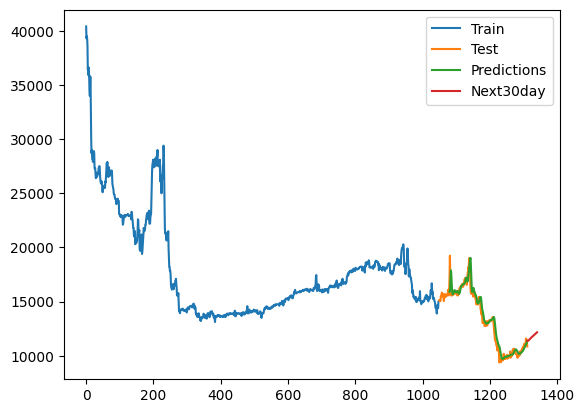

In [28]:
# 13.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+31, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predictions','Next30day'])
plt.show()

# DP3 Historical Data

In [30]:
# 2. Đọc file csv và gắn index với giá Close
data = pd.read_csv('DP3 Historical Data.csv')

# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
data["Change %"] = data["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

data

df1=data.reset_index()['Price']

In [32]:
data

,Date,Price,Open,High,Low,Vol.,Change %
0,05/31/2024,61600.0,61500.0,61700.0,61500.0,10.51K,0.0016
1,05/30/2024,61500.0,61000.0,61500.0,60700.0,5.11K,0.0082
2,05/29/2024,61000.0,62000.0,62000.0,61000.0,7.30K,0.0000
3,05/28/2024,61000.0,61000.0,61800.0,60900.0,7.90K,0.0016
4,05/27/2024,60900.0,61700.0,61700.0,60900.0,12.67K,-0.0016
...,...,...,...,...,...,...,...
1132,03/07/2019,76300.0,75000.0,76900.0,74700.0,11.57K,0.0214
1133,03/06/2019,74700.0,74100.0,75000.0,74000.0,3.81K,0.0040
1134,03/05/2019,74400.0,75000.0,75000.0,74000.0,7.33K,-0.0067
1135,03/04/2019,74900.0,73800.0,75200.0,73800.0,8.34K,0.0149


In [31]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [34]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [35]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [36]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [37]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [38]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step, 1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [39]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.1142 - val_loss: 0.0054
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0238 - val_loss: 0.0049
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0086 - val_loss: 0.0013
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0061 - val_loss: 7.7369e-04
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0064 - val_loss: 7.0428e-04
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0061 - val_loss: 6.3556e-04
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0055 - val_loss: 6.6164e-04
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0052 - val_loss: 6.1174e-04
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0050 - val_loss: 6.4415e-04
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0046 - val_loss: 6.3072e-04
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0036 - val_loss: 4.4581e-04
Epoch 12/100
14/14 ━

In [40]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

y_pred_new = scaler.inverse_transform(y_pred.reshape(1, -1))
y_test_new = scaler.inverse_transform(np.array([y_test], dtype=np.float32))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


In [41]:
# 11 Tính toán RMSE, MAPE và MSLE

test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 2128.0547
MAPE trên tập test là: 2.5721007958054543 %
MSLE trên tập test là: 0.0009834068


In [42]:
# 12. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<30):
    if(len(temp_input)>x_input.shape[1]):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.3373916]
169
1 day input [0.28699974 0.2972834  0.28871369 0.28871369 0.28442883 0.28442883
 0.28014397 0.28014397 0.28014397 0.28014397 0.28014397 0.28014397
 0.28442883 0.28442883 0.29214157 0.2732882  0.28442883 0.28871369
 0.28871369 0.27585911 0.28014397 0.2252978  0.28014397 0.28442883
 0.28014397 0.29299854 0.28100094 0.28014397 0.26814637 0.26214757
 0.26043363 0.26386151 0.26300454 0.26300454 0.26300454 0.26300454
 0.26300454 0.26300454 0.26471848 0.2672894  0.26986031 0.26557546
 0.26557546 0.26557546 0.26300454 0.26300454 0.2672894  0.2672894
 0.26386151 0.26643243 0.26814637 0.27500214 0.27500214 0.27585911
 0.27585911 0.27157426 0.27157426 0.2672894  0.26814637 0.2672894
 0.26557546 0.27157426 0.28014397 0.28871369 0.28699974 0.28871369
 0.26300454 0.25786271 0.26300454 0.26300454 0.26300454 0.26300454
 0.26300454 0.27585911 0.27157426 0.26300454 0.27157426 0.27157426
 0.2672894  0.26300454 0.27157426 0.27757306 0.26300454 0.26300454
 0.26300454 0.26300454 0.26300454 0.

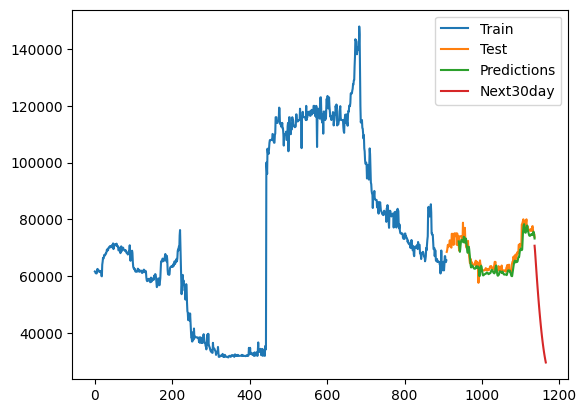

In [44]:
# 13.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+31, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predictions','Next30day'])
plt.show()